In [11]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

if 'aigents_api' in sys.modules:
    del sys.modules['aigents_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from pygents.learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from pygents.aigents_api import TextMetrics

model_family = 'multiclass_view_cleaned'
if not os.path.exists('data/models/distortions/overfitting_babacan_multiclass/'+model_family+'/'):
    os.makedirs('data/models/distortions/overfitting_babacan_multiclass/'+model_family+'/')

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = 'data/models/distortions/overfitting_babacan_multiclass/'+model_family+'/' + m + '.txt'
    return metrics

In [ ]:
from datasets import load_dataset

# dataset: https://huggingface.co/datasets/halilbabacan/combined_synthetic_cognitive_distortions/tree/main
ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,John walked past me without saying a word He m...,NaN,Mind Reading,NaN
1,"During the meeting, Sarah didn't look at me on...",NaN,Mind Reading,NaN
2,Mike didn't respond to my text right away He m...,NaN,Mind Reading,NaN
3,Jessica didn't smile when she saw me She must ...,NaN,Mind Reading,NaN
4,Tom didn't invite me to his party He must not ...,NaN,Mind Reading,NaN
...,...,...,...,...
4526,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
4527,Now I am at university my peers around me all ...,NaN,Overgeneralization,NaN
4528,He claims he’s severely depressed and has outb...,NaN,Mental filter,NaN
4529,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [13]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram

def create_model_files(filtered_model_ngram):
    # Create .txt files for each distortion
    output_dir = "data/models/distortions/overfitting_babacan_multiclass/"+model_family
    distortion_file_path = f"{output_dir}/Distortion.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram)
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No_Distortion'}))

### Evaluate functions

In [14]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [15]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()


def analyse_dataset(ngram_max, df, print_or_plot, ngram_selection_metric = None, ngram_inclusion_threshold = None):
    
    tfidf = count_ngrams_plus_tf_idf(df,ngram_max,binary=False, clean_punct=True)
    
    distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
    norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,ngram_max,binary=False, clean_punct=True)
        
    selection_metrics = {
        'TF-IDF': tfidf,
        'F':frequency,
        'UF':unique_frequency,
        'FN':frequency_self_normalized,
        'UFN':unique_frequency_self_normalized,
        'UFN/D/D':norm_uniq_n_gram_dicts,
        'FN*UFN':norm_norm_uniq,
        'FN*UFN/D':norm_norm_uniq_norm,
        'CFR':cfr,
        'FCR':fcr,
        'MR':mr,
        'NLMI':nl_mi}
    
    ngram_inclusion_thresholds = [ngram_inclusion_threshold] if ngram_inclusion_threshold is not None else [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
    ngram_selection_metric = [ngram_selection_metric] if ngram_selection_metric is not None else list(selection_metrics.keys())
    
    for inclusion_threshold in ngram_inclusion_thresholds:
        for selection_metric in ngram_selection_metric:
            model_ngram = selection_metrics[selection_metric]
            
            # Filter out values below the threshold
            filtered_model_ngram = ngrams_inclusion(model_ngram, inclusion_threshold)

            # Create .txt files for each distortion
            distortions_labels = create_model_files(filtered_model_ngram)
            tm = TextMetrics(language_metrics(distortions_labels), encoding = "utf-8", debug=False)

            if print_or_plot == 'print_results':
                print('\nN-gram selection metric:', selection_metric)
                print('N-gram max length:', ngram_max)
                print('N-gram inclusion threshold:', inclusion_threshold)

                print('\tAny distortion (threshold, accuracy, F1 score):')
    
            any_res_acc = {}
            any_res = {}
            for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                acc, f1 = evaluate_df_acc_f1(df,our_evaluator_any,threshold, tm)
                any_res_acc[threshold] = acc
                any_res[threshold] = f1
                if print_or_plot == 'print_results':
                    print('\t', threshold, acc, f1)

            min_acc = min(any_res_acc.values())
            max_acc = max(any_res_acc.values())
            avg_acc = sum(any_res_acc.values()) / len(any_res_acc)

            min_f1 = min(any_res.values())
            max_f1 = max(any_res.values())
            avg_f1 = sum(any_res.values()) / len(any_res)

            if print_or_plot == 'print_results':
                print(f"\n\tAccuracy: min={min_acc}, max={max_acc}, avg={avg_acc}")
                print(f"\tF1 Score: min={min_f1}, max={max_f1}, avg={avg_f1}")
        

            avg_res_acc = {}
            avg_res = {}
            if print_or_plot == 'print_results':
                print('\n\tAverage distortion (threshold, accuracy, F1 score):')
            for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                acc, f1 = evaluate_df_acc_f1(df,our_evaluator_avg,threshold, tm)
                avg_res_acc[threshold] = acc
                avg_res[threshold] = f1
                if print_or_plot == 'print_results':
                    print('\t', threshold, acc, f1)

            min_acc = min(avg_res_acc.values())
            max_acc = max(avg_res_acc.values())
            avg_acc = sum(avg_res_acc.values()) / len(any_res_acc)

            min_f1 = min(avg_res.values())
            max_f1 = max(avg_res.values())
            avg_f1 = sum(avg_res.values()) / len(any_res)

            if print_or_plot == 'print_results':
                print(f"\n\tAccuracy: min={min_acc}, max={max_acc}, avg={avg_acc}")
                print(f"\tF1 Score: min={min_f1}, max={max_f1}, avg={avg_f1}")
    
    return any_res_acc, avg_res_acc

# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [16]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]

for ngram_max in ngram_max_values:
    acc_data_any, acc_data_avg = analyse_dataset(ngram_max, df, 'print_results')


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	Any distortion (threshold, accuracy, F1 score):
	 0.1 0.7227373068432671 0.8383942357179619
	 0.2 0.7384105960264901 0.8449561690435693
	 0.3 0.7496688741721854 0.8395585738539898
	 0.4 0.7194260485651214 0.7928280358598206
	 0.5 0.5282560706401767 0.5780848963474827
	 0.6 0.30353200883002207 0.21886605595444414
	 0.7 0.21236203090507727 0.015995587424158852
	 0.8 0.20596026490066224 0
	 0.9 0.20596026490066224 0

	Accuracy: min=0.20596026490066224, max=0.7496688741721854, avg=0.48736816286485163
	F1 Score: min=0, max=0.8449561690435693, avg=0.45874261713349196

	Average distortion (threshold, accuracy, F1 score):
	 0.1 0.7231788079470198 0.8386100386100386
	 0.2 0.7715231788079471 0.8607935440484197
	 0.3 0.7832229580573952 0.8517512077294686
	 0.4 0.6911699779249448 0.7613849565069076
	 0.5 0.44260485651214126 0.4591989719426002
	 0.6 0.22781456953642384 0.05357142857142857
	 0.7 0.20662251655629138

### Our best model obtained through the optimal combination of hyper-parameters

In [21]:
# Best model
acc_data = analyse_dataset(3, df, 'print_results', 'UFN', 30)


N-gram selection metric: UFN
N-gram max length: 3
N-gram inclusion threshold: 30
	Any distortion (threshold, accuracy, F1 score):
	 0.1 0.7942604856512141 0.8853064238247601
	 0.2 0.7944812362030905 0.8854153846153846
	 0.3 0.7984547461368653 0.887381275440977
	 0.4 0.8567328918322296 0.9172510518934082
	 0.5 0.9622516556291391 0.9767820773930753
	 0.6 0.9955849889624724 0.9972276129747712
	 0.7 0.9995584988962473 0.999722067815453
	 0.8 0.9997792494481236 0.9998610145934677
	 0.9 0.9982339955849889 0.9988870339454646

	Accuracy: min=0.7942604856512141, max=0.9997792494481236, avg=0.9110375275938191
	F1 Score: min=0.8853064238247601, max=0.9998610145934677, avg=0.9497593269440847

	Average distortion (threshold, accuracy, F1 score):
	 0.1 0.7942604856512141 0.8853064238247601
	 0.2 0.7958057395143487 0.8860697130188447
	 0.3 0.8781456953642384 0.9287374128582494
	 0.4 0.9823399558498896 0.9889685603971318
	 0.5 0.9810154525386313 0.9879077615298087
	 0.6 0.9390728476821192 0.960104076

# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

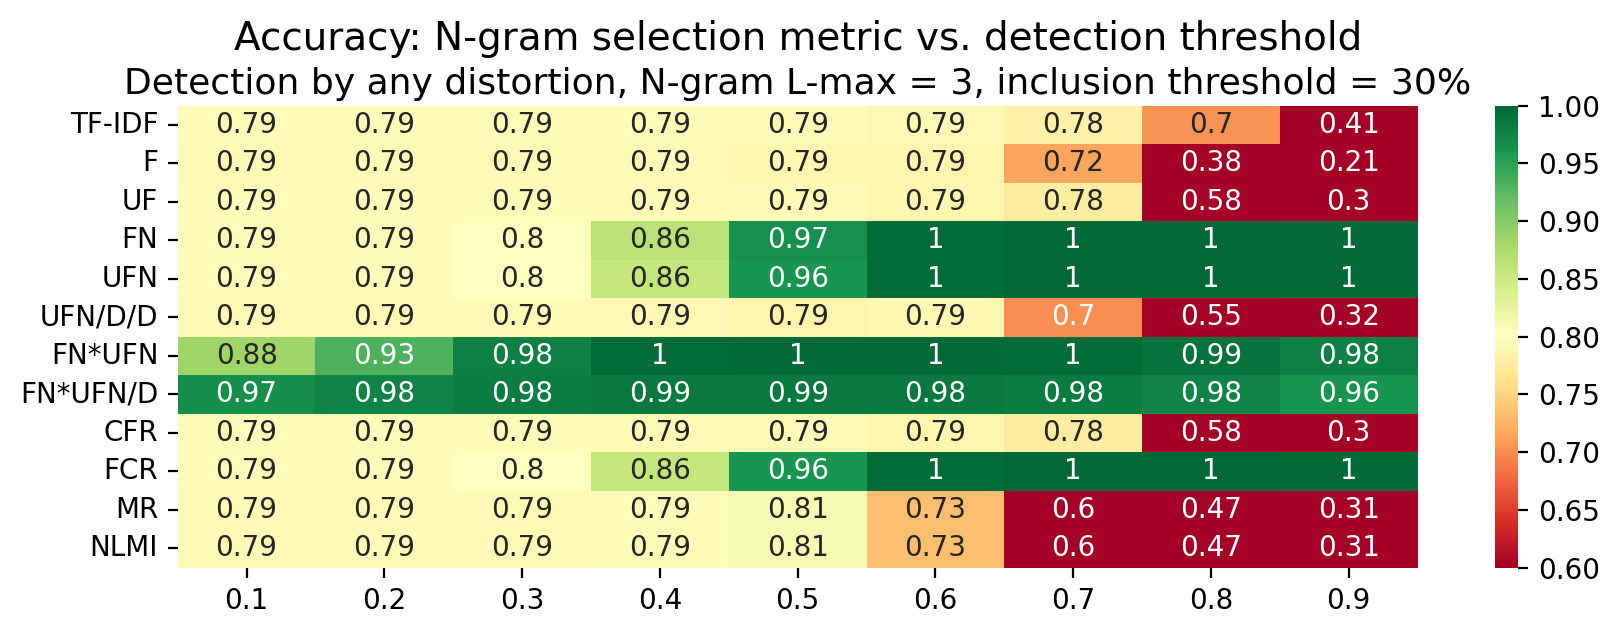

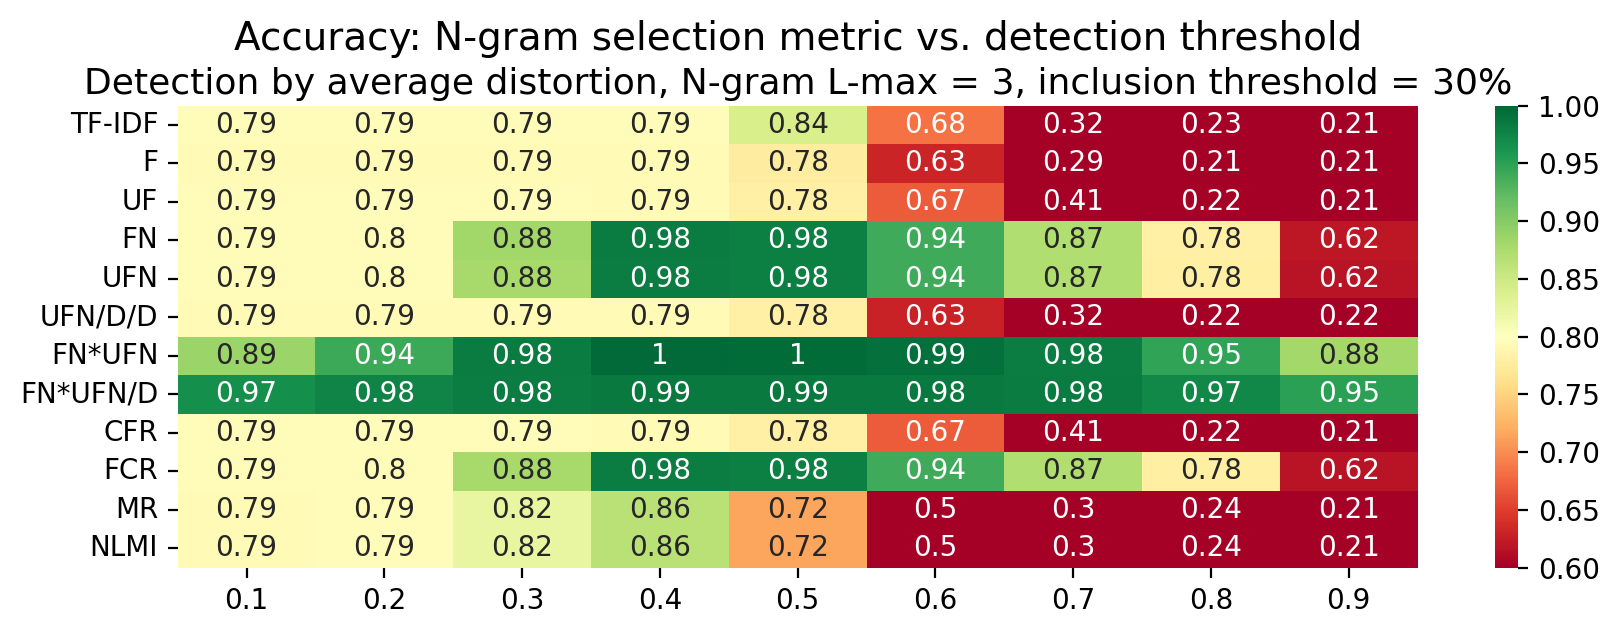

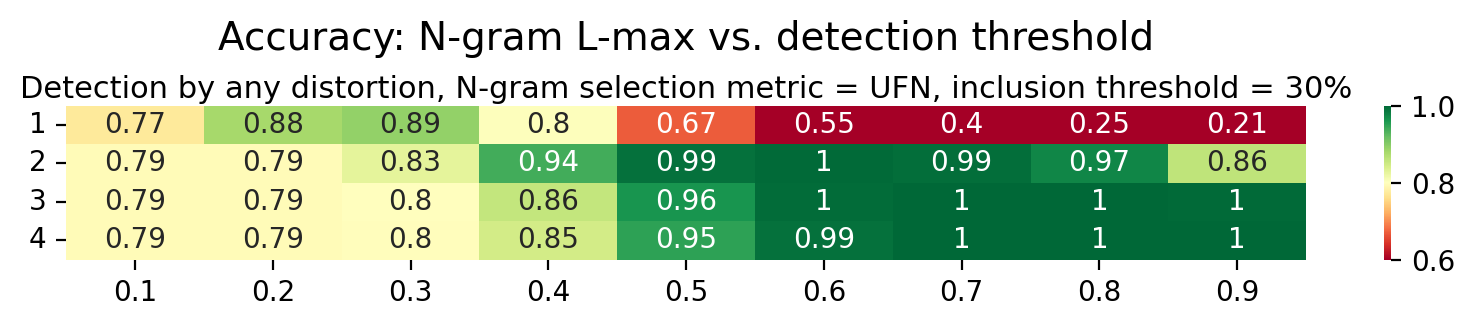

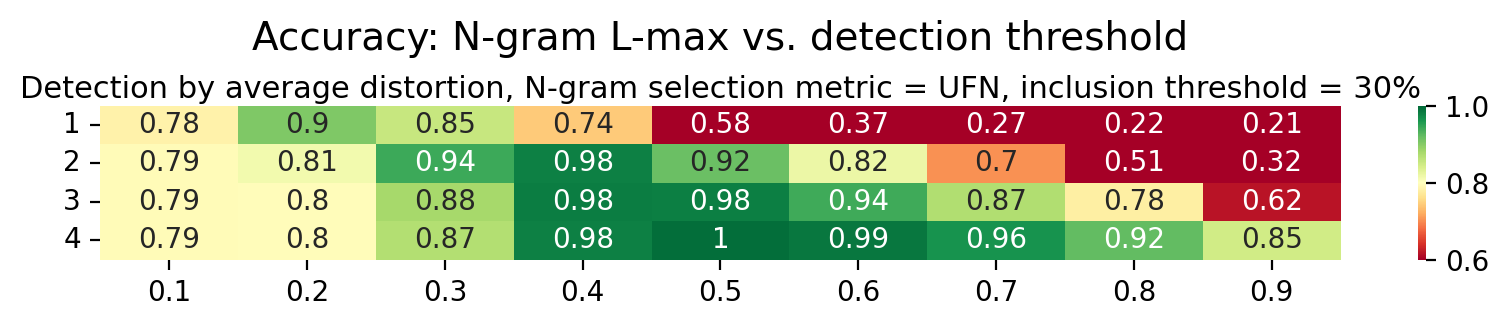

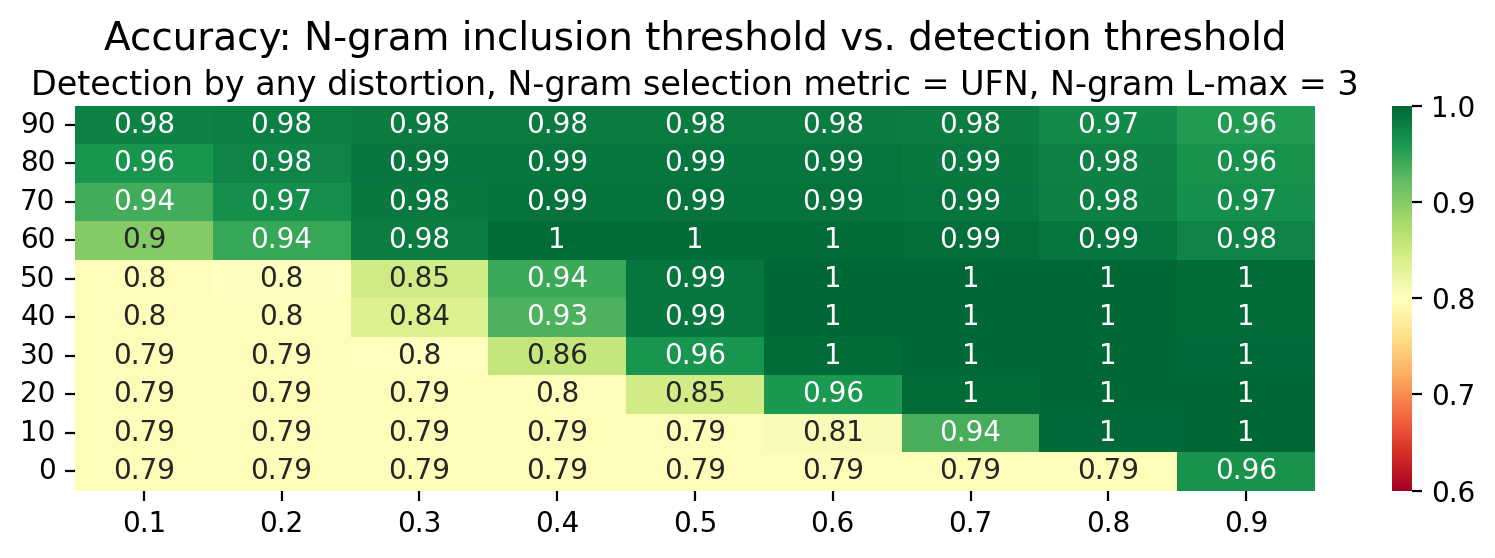

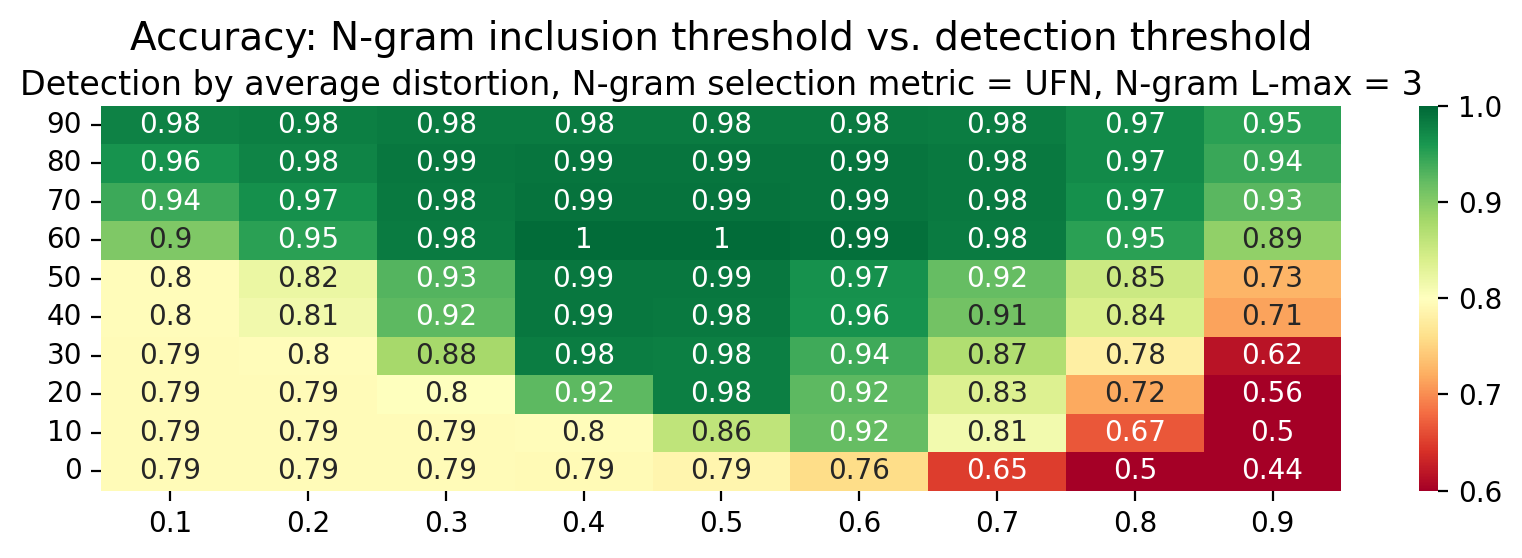

In [22]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 1) N-gram selection metric - threshold
acc_analytics_threshold_any = np.zeros((len(ngram_selection_metrics), len(thresholds)))
acc_analytics_threshold_avg = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):
    acc_data_any, acc_data_avg = analyse_dataset(3, df, 'plot_results', ngram_selection_metric, 30)
    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold_any[i, j] = acc_data_any[threshold]
        acc_analytics_threshold_avg[i, j] = acc_data_avg[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_any, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by any distortion, N-gram L-max = 3, inclusion threshold = 30%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_avg, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by average distortion, N-gram L-max = 3, inclusion threshold = 30%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)


# 2) ngram_max - threshold
acc_ngrammax_threshold_any = np.zeros((len(ngram_max_values), len(thresholds)))
acc_ngrammax_threshold_avg = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):
    acc_data_any, acc_data_avg = analyse_dataset(ngram_max, df, 'plot_results', ngram_selection_metric = 'UFN', ngram_inclusion_threshold = 30)
    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold_any[i, j] = acc_data_any[threshold]
        acc_ngrammax_threshold_avg[i, j] = acc_data_avg[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_any, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = UFN, inclusion threshold = 30%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_avg, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = UFN, inclusion threshold = 30%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

            
# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold_any = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))
acc_ngram_inclusion_threshold_avg = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):
    acc_data_any, acc_data_avg = analyse_dataset(3, df, 'plot_results', 'UFN', ngram_inclusion_threshold)
    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold_any[i, j] = acc_data_any[threshold]
        acc_ngram_inclusion_threshold_avg[i, j] = acc_data_avg[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_any, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = UFN, N-gram L-max = 3",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_avg, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = UFN, N-gram L-max = 3",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

### Final saving of the best model

In [23]:
# Best model
acc_data = analyse_dataset(3, df, 'print_results', 'UFN', 30)


N-gram selection metric: UFN
N-gram max length: 3
N-gram inclusion threshold: 30
	Any distortion (threshold, accuracy, F1 score):
	 0.1 0.7942604856512141 0.8853064238247601
	 0.2 0.7944812362030905 0.8854153846153846
	 0.3 0.7984547461368653 0.887381275440977
	 0.4 0.8567328918322296 0.9172510518934082
	 0.5 0.9622516556291391 0.9767820773930753
	 0.6 0.9955849889624724 0.9972276129747712
	 0.7 0.9995584988962473 0.999722067815453
	 0.8 0.9997792494481236 0.9998610145934677
	 0.9 0.9982339955849889 0.9988870339454646

	Accuracy: min=0.7942604856512141, max=0.9997792494481236, avg=0.9110375275938191
	F1 Score: min=0.8853064238247601, max=0.9998610145934677, avg=0.9497593269440847

	Average distortion (threshold, accuracy, F1 score):
	 0.1 0.7942604856512141 0.8853064238247601
	 0.2 0.7958057395143487 0.8860697130188447
	 0.3 0.8781456953642384 0.9287374128582494
	 0.4 0.9823399558498896 0.9889685603971318
	 0.5 0.9810154525386313 0.9879077615298087
	 0.6 0.9390728476821192 0.960104076

In [20]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'7:41:39.102423'